In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("winequality-white.csv", delimiter=';')

In [3]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [5]:
dataset['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d42e63358>,
      dtype=object)

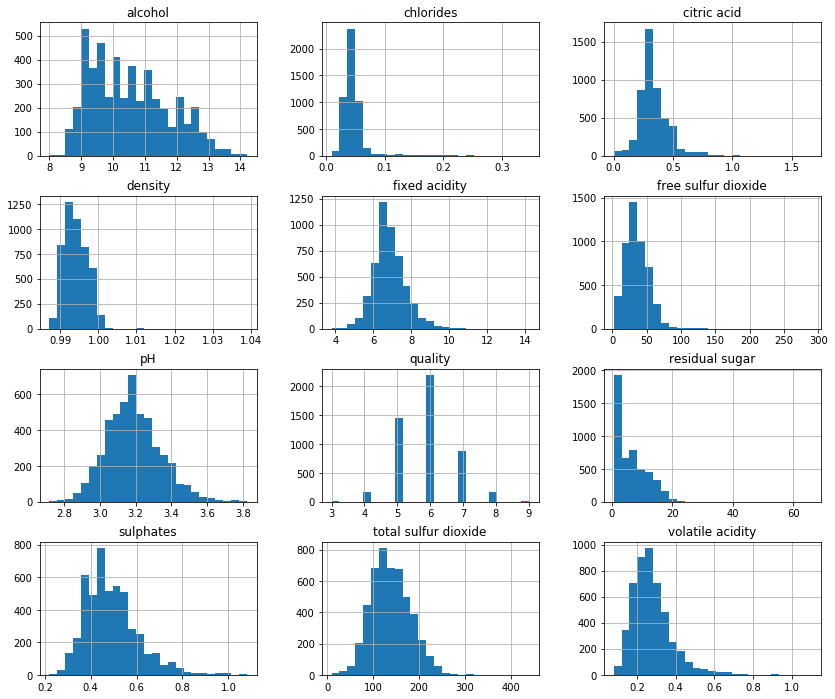

In [6]:
dataset.hist(bins=25, figsize=(14, 12))

In [9]:
corr_matrix = dataset.corr()
corr_matrix['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d3f933ba8>,
      dtype=object)

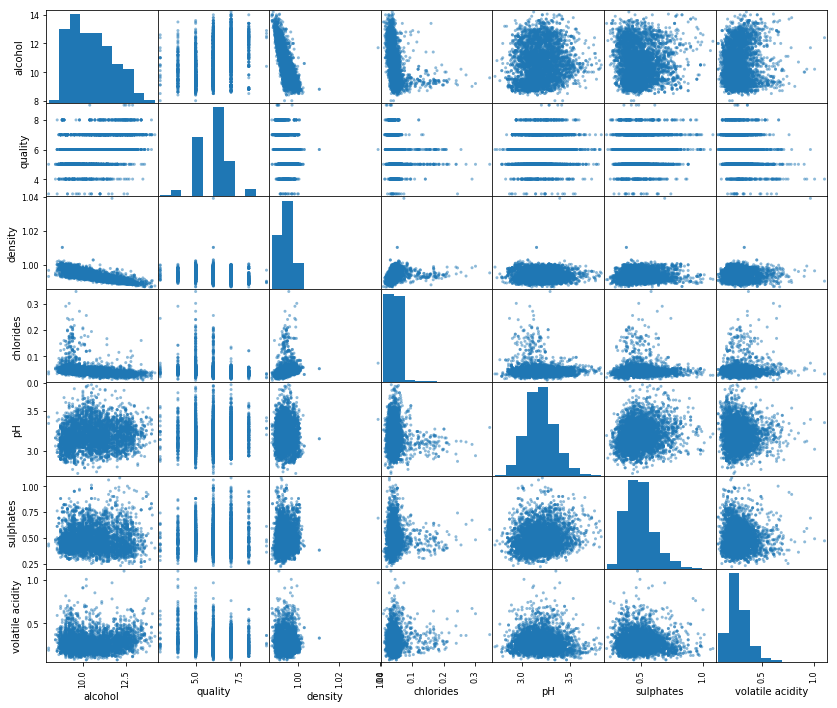

In [10]:
from pandas.plotting import scatter_matrix

attributes = ['alcohol', 'quality', 'density', 'chlorides', 'pH', 'sulphates', 'volatile acidity']
scatter_matrix(dataset[attributes], figsize=(14, 12))

In [11]:
X_data = dataset[attributes].values
m, n = X_data.shape

y_data = dataset['quality'].values

In [12]:
n_inputs = n
n_hidden1 = 200
n_hidden2 = 50
n_outputs = 10

In [13]:
test_ratio = 0.2
test_size = int(m*test_ratio)

X_train = X_data[:-test_size]
X_test = X_data[-test_size:]
y_train = y_data[:-test_size]
y_test = y_data[-test_size:]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
def random_batch(X_train, y_train, batch_size):
    rnd_indicies = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indicies]
    y_batch = y_train[rnd_indicies]
    return X_batch, y_batch

In [16]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int64, shape=(None), name='y')

In [17]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name='kernel')
        b = tf.Variable(tf.zeros([n_neurons]), name='bias')
        Z = tf.matmul(X, W) + b
        
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [18]:
with tf.name_scope("gsn"):
    hidden1 = neuron_layer(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name='output')

In [19]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [20]:
learning_rate = 0.01

with tf.name_scope("learning"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [21]:
with tf.name_scope("rating"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
n_epochs = 40
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

In [24]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        print("Epoch", epoch, "Train acc: {:.3f}".format(acc_train), "Test acc: {:.3f}".format(acc_test))
        
    save_path = saver.save(sess, "./wine_quality_model.ckpt")    

Epoch 0 Train acc: 0.880 Test acc: 0.872
Epoch 1 Train acc: 0.920 Test acc: 0.920
Epoch 2 Train acc: 0.940 Test acc: 0.923
Epoch 3 Train acc: 0.920 Test acc: 0.941
Epoch 4 Train acc: 0.940 Test acc: 0.936
Epoch 5 Train acc: 0.940 Test acc: 0.943
Epoch 6 Train acc: 0.980 Test acc: 0.935
Epoch 7 Train acc: 0.920 Test acc: 0.940
Epoch 8 Train acc: 0.960 Test acc: 0.940
Epoch 9 Train acc: 0.980 Test acc: 0.946
Epoch 10 Train acc: 0.960 Test acc: 0.947
Epoch 11 Train acc: 0.960 Test acc: 0.944
Epoch 12 Train acc: 0.960 Test acc: 0.946
Epoch 13 Train acc: 0.980 Test acc: 0.946
Epoch 14 Train acc: 0.940 Test acc: 0.948
Epoch 15 Train acc: 0.960 Test acc: 0.946
Epoch 16 Train acc: 1.000 Test acc: 0.942
Epoch 17 Train acc: 0.980 Test acc: 0.951
Epoch 18 Train acc: 0.960 Test acc: 0.953
Epoch 19 Train acc: 1.000 Test acc: 0.954
Epoch 20 Train acc: 1.000 Test acc: 0.956
Epoch 21 Train acc: 1.000 Test acc: 0.956
Epoch 22 Train acc: 0.940 Test acc: 0.957
Epoch 23 Train acc: 0.980 Test acc: 0.960
Ep